# Decision Tree Lab

<a target="_blank" href="https://colab.research.google.com/github/dahenderson98/Decision-Tree/blob/main/DecisionTree.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.utils import shuffle
from sklearn import preprocessing
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt

## 1. Implement the ID3 decision tree algorithm  
- Use standard information gain as your basic attribute evaluation metric.  Note that ID3 would usually augment information gain with a mechanism to penalize statistically insignificant attribute splits to avoid overfit (e.g. early stopping, gain ratio, etc.)
- Include the ability to handle unknown attributes by making "unknown" a separate output class.
- You do not need to handle real valued attributes.
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use simple data sets (like the lenses data and the pizza homework), which you can check by hand, to test each detailed step of your algorithm to make sure it works correctly. 

In [ ]:
from os import sendfile
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self,counts=None,counts_given=False):
        """ Initialize class with chosen hyperparameters.
        Args:
        Optional Args (Args we think will make your life easier):
            counts: A list of Ints that tell you how many types of each feature there are
        Example:
            DT  = DTClassifier()
            or
            DT = DTClassifier(count = [2,3,2,2])
            Dataset = 
            [[0,1,0,0],
            [1,2,1,1],
            [0,1,1,0],
            [1,2,0,1],
            [0,0,1,1]]

        """
        self.counts = counts
        self.counts_given = counts_given
        

    def fit(self, X, y, counts_given=False, debug=False, print_flag=False):
        """ Fit the data; Make the Decision tree

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 1D numpy array with the training targets

        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        # Commit data to memory
        # Data sublists will be lists of indices referencing master dataset
        self.X, self.y = X, y

        # Get list of unique value counts for all inputs if counts not given
        if not counts_given:
          self.counts = self.get_unique_counts()
          if (debug): print("Comp\'d Counts:", self.counts)

        # Calculate initial information value and majority class for dataset
        output_vals, output_counts = np.unique(self.y, return_counts=True)
        self.majority_class = output_vals[np.argmax(output_counts)]
        if (debug): print("Output Counts:", output_counts)
        self.starting_info = np.sum( [ -((i/self.X.shape[0]) * np.log2(i/self.X.shape[0])) for i in output_counts ] )
        if (debug): print("Starting Info:", self.starting_info,"\n")

        # Initialize remaining inputs list with all starting inputs
        remaining_inputs = [ i for i in range( self.X.shape[1] ) ]

        # Create initial node with base information of the dataset
        self.top_node = Node(info=self.starting_info)

        # Build decision tree starting from initial node
        self.build_tree(parent_node=self.top_node, data_X=self.X, data_y=self.y, remaining_inputs=remaining_inputs, print_flag=print_flag, debug=debug)

        return self

    # Recursive function builds out decision tree by splitting at input indices
    def build_tree(self, parent_node, data_X, data_y, remaining_inputs, print_flag, debug):      
      
      # If no remaining inputs (no further splits possible) or no data instances to work with, set parent node's output class 
      # to most common output class and is_leaf_node to True. -> Return
      if len(remaining_inputs) == 0 or data_X.shape[0] == 0:
        parent_input_vals, parent_input_counts = np.unique(data_y, return_counts=True)
        parent_node.output_class = parent_input_vals[ np.argmax(parent_input_counts) ]
        parent_node.is_leaf_node = True
        if print_flag: print("Leaf Node Reached - Output:", parent_node.output_class,"\n")
        return
      
      # For each input, calculate information gain from splitting on it
      best_info, best_info_gain, best_split_index = parent_node.info, 0, -1
      best_input_vals, best_input_counts = [], []

      if debug: print("Looking for next best split\n")
      concat = np.concatenate((data_X, data_y), axis=1)
      for i in remaining_inputs:
        if debug: print("Scoring a split on index:", i)
        input_vals, input_counts = np.unique( data_X[:,i], return_counts=True) 
        if debug: print("Input_vals:", input_vals, "Input_counts", input_counts)
        # Sum up info for each input class coupled with each output class
        new_info = 0
        for j in range(len(input_counts)):
          input_portion = input_counts[j]
          input_val = input_vals[j]
          filtered_data = np.array( list( filter( lambda x: x[i] == input_val, concat) ) )
          _, output_counts = np.unique( filtered_data[:,-1], return_counts=True )
          if debug: print("Input_val:", input_val, "Output_counts:", output_counts)
          new_info += (input_portion/concat.shape[0]) * (np.sum( [ -((k/input_portion)*np.log2(k/input_portion)) for k in output_counts ] ))
          if debug: print("New Info so far:", new_info)
        if debug: print("\n")
        info_gain = self.starting_info - new_info
        if info_gain > best_info_gain:
          best_info = new_info
          best_info_gain = info_gain
          best_split_index = i
          best_input_vals = input_vals
          best_input_counts = input_counts

      if debug:
        print("Eval Complete: All indices scored")
        print("best_split_index:", best_split_index)
        print("best_info:", best_info)
        print("best_info_gain:", best_info_gain)
        print("best_input_vals:", best_input_vals)
        print("best_input_counts:", best_input_counts,"\n")
      
      # If no information gained from possible splits, set parent node's output class to most common output class and is_leaf_node to True 
      if best_info_gain == 0:
        parent_input_vals, parent_input_counts = np.unique(data_y, return_counts=True)
        parent_node.output_class = parent_input_vals[ np.argmax(parent_input_counts) ]
        parent_node.is_leaf_node = True
        if print_flag: print("No beneficial splits left - Output:", parent_node.output_class,"\n")
        return
      
      # Split on the input with the greatest information gain
      if print_flag: print("Splitting on input index:", best_split_index, "Info Gain:", best_info_gain)
      if debug: print("Should make", self.counts[best_split_index], "children","\n")
      for i in range(self.counts[best_split_index]):
        if i >= len(best_input_vals): break
        input_val = best_input_vals[i]
        # Determine new subset of data to pass to next node
        composite_data = np.concatenate( (data_X, data_y.reshape(-1,1)), axis=1 )
        filtered_composite_data = np.array( list(filter(lambda x: x[best_split_index] == input_val, composite_data)) )
        new_X, new_y = filtered_composite_data[:,:-1], filtered_composite_data[:,-1].reshape(-1,1)
        if print_flag: print("\nExpanding child ", best_input_vals[i], " of input index ", best_split_index, "\n")
        
        # If outputs are pure for this branch, make parent a leaf node and continue with other branches in this split
        y_vals, y_val_counts = np.unique(new_y, return_counts=True)
        if len(y_vals) == 1:
          child_node = Node(info=best_info, parent_node=parent_node, split_index=best_split_index, value=best_input_vals[i], is_leaf_node=True, output_class=y_vals[0])
          parent_node.add_child(child_node)
          if print_flag: print("Index", best_split_index, "=", input_val, "\n\tPrediction:", y_vals[0],"\n")
          

        # Else, get list of remaining input indices minus the index we're splitting on
        # Then create a child node for the current input_val and call build_tree on it
        else: 
          new_remaining_inputs = list(filter(lambda x: x != best_split_index, remaining_inputs))
          child_node = Node(info=best_info, parent_node=parent_node, split_index=best_split_index, value=input_val)
          parent_node.add_child(child_node)
          self.build_tree(parent_node=child_node, data_X=new_X, data_y=new_y, remaining_inputs=new_remaining_inputs, print_flag=print_flag, debug=debug)

      return

    # Get list of unique counts for all input columns of dataset
    def get_unique_counts(self):
      return [len( np.unique( self.X[:,i].reshape(1,-1) ) ) for i in range( self.X.shape[1] )]

    def to_str(self):
      _str = ""
      indent_depth = 0
      for i in range(len(self.top_node.children)):
        _str += self.to_str_helper(self.top_node.children[i], indent_depth)
      return _str

    def to_str_helper(self, node, indent_depth):
      _str = ""
      _str += "-- " * indent_depth
      _str += "Input " + str(node.split_index) + " = " + str(node.value) + ": " + str(self.starting_info - node.info) + "\n"
      if node.is_leaf_node:
        _str += "-- " * (indent_depth + 1)
        _str += "prediction: " + str(node.output_class) + "\n"
      else:
        for c in range(len(node.children)):
          _str += self.to_str_helper(node.children[c], indent_depth+1)

      return _str

    def predict(self, X):
        """ Predict all classes for a dataset X

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets

        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        predictions = []
        # Get predicted output for each row of X
        for i in range(X.shape[0]):
          current_node = self.top_node
          traversing = True
          while traversing:
            moved = False
            # If we've hit a leaf node, append current_node's output class to predictions as the prediction for this instance
            if current_node.is_leaf_node or len(current_node.children) == 0:
              predictions.append(current_node.output_class)
              moved = True
              traversing = False
            # Iterate over current_node's children to find the child whose value matches the instance at child's split_index
            for j in range(len(current_node.children)):
              if current_node.children[j].value == X[i, current_node.children[j].split_index ]:
                current_node = current_node.children[j]
                moved = True
                break
            # If we haven't found a match in Node's children, and we're not in a leaf node, we have an unfamiliar instance
            # Append dataset's most common output class to predictions as the prediction for this instance
            if not moved: 
              predictions.append(self.majority_class)
              break
        
        return predictions

    def score(self, X, y, mse=False):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """
        # Call predict on all instances in X, compare outputs to y, return float ratio of correct predictions and total outputs
        predictions = self.predict(X)
        accuracy = np.sum( [ 1 if predictions[i] == y[i] else 0 for i in range(X.shape[0]) ] ) / X.shape[0]
        # get MSE as well
        return accuracy
    
class Node:
  def __init__(self, info, parent_node=None, split_index=None, value=None, is_leaf_node=False, output_class=None):
    self.info = info
    self.parent_node = parent_node
    self.split_index = split_index
    self.value = value
    self.is_leaf_node = is_leaf_node
    self.output_class = output_class
    self.children = []

  def add_child(self, child):
    self.children.append(child)



### 1.1 (20%) Debug 

- Debug your model by training on the lenses dataset: [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff)
- Test your model on the lenses test set: [Debug Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff)
- Parameters:
For this problem the number of unique feature values for each feature is: counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)
---

Expected Results: Accuracy = [0.33]

Information gain at splits = [0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

Predictions should match this file: [Lenses Predictions](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv)

*NOTE: The [Lenses Prediction](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv) uses the following encoding: soft=2, hard=0, none=1. Use this same encoding.*

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits and information gains should look like, with the corresponding child node predictions:

<pre>
tear_prod_rate = normal: 0.5487949406953987
    astigmatism = no: 0.7704260414863775
        age = pre_presbyopic: 0.3166890883150208
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope: 1.0
                prediction: soft
            spectacle_prescrip = myope:
                prediction: none
        age = young:
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope: 0.4591479170272447
            age = pre_presbyopic: 0.9182958340544894
                prediction: none
            age = presbyopic:
                prediction: none
            age = young:
                prediction: hard
        spectacle_prescrip = myope:
            prediction: hard
tear_prod_rate = reduced:
    prediction: none
</pre>

In [ ]:
# Load debug training data
!curl -o debug_training_data.arff 'https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff'
debug_training_data = np.array(arff.loadarff('debug_training_data.arff')[0].tolist())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2890  100  2890    0     0   8892      0 --:--:-- --:--:-- --:--:--  8892


In [ ]:
X_debug_training, y_debug_training = debug_training_data[:,:-1], debug_training_data[:,-1].reshape(-1,1)

# 0. age of the patient:      (0) young,   (1) pre-presbyopic, (2) presbyopic
# 1. spectacle prescription:  (0) myope,   (1) hypermetrope
# 2. astigmatic:              (0) no,      (1) yes
# 3. tear production rate:    (0) reduced, (1) normal

# Train Decision Tree
debug_training_counts = [3, 2, 2, 2]
debug_dt = DTClassifier(counts=debug_training_counts)
_ = debug_dt.fit(X_debug_training, y_debug_training, counts_given=True)

In [ ]:
# Load debug test data
!curl -o debug_test_data.arff 'https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff'
debug_test_data = np.array(arff.loadarff('debug_test_data.arff')[0].tolist())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2839  100  2839    0     0  16798      0 --:--:-- --:--:-- --:--:-- 16798


In [ ]:
X_debug_test, y_debug_test = debug_test_data[:,:-1], debug_test_data[:,-1].reshape(-1,1)

# Execute and print the model accuracy and the information gain of every split you make
accuracy_debug = debug_dt.score(X=X_debug_test, y=y_debug_test)
print("Debug Test Accuracy:", "%.2f" % accuracy_debug, "\n")
print("Decision Tree:\n\n",debug_dt.to_str())

Debug Test Accuracy: 0.33 

Decision Tree:

 Input 3 = b'normal': 0.5487949406953982
-- Input 2 = b'no': 0.5419283975128762
-- -- Input 0 = b'pre_presbyopic': 0.9927541920309648
-- -- -- prediction: b'soft'
-- -- Input 0 = b'presbyopic': 0.9927541920309648
-- -- -- Input 1 = b'hypermetrope': 1.326087525364298
-- -- -- -- prediction: b'soft'
-- -- -- Input 1 = b'myope': 1.326087525364298
-- -- -- -- prediction: b'none'
-- -- Input 0 = b'young': 0.9927541920309648
-- -- -- prediction: b'soft'
-- Input 2 = b'yes': 0.5419283975128762
-- -- Input 1 = b'hypermetrope': 0.8669396083370533
-- -- -- Input 0 = b'pre_presbyopic': 1.326087525364298
-- -- -- -- prediction: b'none'
-- -- -- Input 0 = b'presbyopic': 1.326087525364298
-- -- -- -- prediction: b'none'
-- -- -- Input 0 = b'young': 1.326087525364298
-- -- -- -- prediction: b'hard'
-- -- Input 1 = b'myope': 0.8669396083370533
-- -- -- prediction: b'hard'
Input 3 = b'reduced': 0.5487949406953982
-- prediction: b'none'



Discussion

The biggest learning moment for me while implementing this algorithm was when I realized how the information gain of any node in the tree is calculated. My initial impression held that information gain was calculated as (Info_parent - Info_node), but in reality information gain is calculated as (Info_base - Info_node). I experienced all kinds of information bugs until I figured that out from the lecture slides.

In [ ]:
# Optional Debugging Dataset - Pizza Homework
#pizza_dataset = np.array([[1,2,0],[0,0,0],[0,1,1],[1,1,1],[1,0,0],[1,0,1],[0,2,1],[1,0,0],[0,2,0]])
#pizza_labels = np.array([2,0,1,2,1,2,1,1,0])
#y_pizza = pizza_labels.reshape(-1,1)
#pizza_dt = DTClassifier()
#_ = pizza_dt.fit(pizza_dataset, y_pizza, debug=True, print_flag=True)

### 1.2 (20%) Evaluation 

- We will evaluate your model based on its performance on the zoo dataset. 
- Train your model using this dataset: [Evaluation Train Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff)
- Test your model on this dataset: [Evaluation Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff)
- Parameters: counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)
---
Your progam should print out your accuracy on the evaluation test dataset and also the information gain of each split you make.

In [ ]:
# Load evaluation training data
!curl -o eval_train_data.arff 'https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff'
eval_train_data = np.array(arff.loadarff('eval_train_data.arff')[0].tolist())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6683  100  6683    0     0  40503      0 --:--:-- --:--:-- --:--:-- 40750


In [ ]:
X_eval_train, y_eval_train = eval_train_data[:,:-1], eval_train_data[:,-1].reshape(-1,1)

# Train Decision Tree
eval_dt = DTClassifier()
_ = eval_dt.fit(X_eval_train, y_eval_train)

In [ ]:
# Load evaluation test data
!curl -o eval_test_data.arff 'https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff'
eval_test_data = np.array(arff.loadarff('eval_test_data.arff')[0].tolist())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  171k  100  171k    0     0   786k      0 --:--:-- --:--:-- --:--:--  786k


In [ ]:
X_eval_test, y_eval_test = eval_test_data[:,:-1], eval_test_data[:,-1].reshape(-1,1)

# Execute and print the model accuracy and the information gain of every split you make
accuracy_eval = eval_dt.score(X=X_eval_test, y=y_eval_test)
print("Evaluation Test Accuracy:", "%.2f" % accuracy_eval, "\n")
print("Decision Tree:\n\n",eval_dt.to_str())

Evaluation Test Accuracy: 0.15 

Decision Tree:

 Input 12 = b'0': 1.3630469031539394
-- Input 11 = b'F': 1.6063860686313394
-- -- Input 7 = b'F': 2.390559682294039
-- -- -- prediction: b'c7'
-- -- Input 7 = b'T': 2.390559682294039
-- -- -- prediction: b'c3'
-- Input 11 = b'T': 1.6063860686313394
-- -- Input 2 = b'F': 2.390559682294039
-- -- -- prediction: b'cT'
-- -- Input 2 = b'T': 2.390559682294039
-- -- -- prediction: b'c4'
Input 12 = b'2': 1.3630469031539394
-- Input 0 = b'F': 2.390559682294039
-- -- prediction: b'c2'
-- Input 0 = b'T': 2.390559682294039
-- -- prediction: b'cT'
Input 12 = b'4': 1.3630469031539394
-- Input 0 = b'F': 2.136573249283428
-- -- Input 5 = b'F': 1.8748967573744946
-- -- -- prediction: b'c3'
-- -- Input 5 = b'T': 1.8748967573744946
-- -- -- Input 7 = b'F': 2.390559682294039
-- -- -- -- prediction: b'c7'
-- -- -- Input 7 = b'T': 2.390559682294039
-- -- -- -- prediction: b'c5'
-- Input 0 = b'T': 2.136573249283428
-- -- prediction: b'cT'
Input 12 = b'5': 1.36

Discussion

The reported accuracy of my decision tree algorithm on this evaluation task was quite poor at only 15%, which was quite surprising. This low accuracy may be due to issue of either too little data being used, or noise in the dataset leading to overfitting. The algorithm did have to determine splits across 12 different inputs, however, which makes it especially prone to overfitting and hypercomplexity given its lack of any normalization tools.

## 2. Learn Cars and Voting Data Sets and Predict accuracy with *n*-fold CV  
- Use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criteria, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, create a table with the training, validation, and test classification accuracy for each of the 10 runs and the average accuracies for the training, validation, and test data. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

### 2.1 (15%) Implement 10-fold Cross Validation and report results for the Cars Dataset
- Use this [Cars Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff)
- Create a table for your *n*-fold cross validation accuracies

*If you are having trouble using scipy's loadarff function (scipy.io.arff.loadarff), try:*

*pip install arff &nbsp;&nbsp;&nbsp;&nbsp;          # Install arff library*

*import arff as arf*                   

*cars = list(arf.load('cars.arff'))   &nbsp;&nbsp;&nbsp;&nbsp;# Load your downloaded dataset (!curl, etc.)*

*df = pd.DataFrame(cars)*  

*There may be additional cleaning needed*

In [ ]:
# Load and shuffle cars data
!curl -o cars_master.arff 'https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff'
cars_master = np.array(arff.loadarff('cars_master.arff')[0].tolist())
X_cars_shuffled, y_cars_shuffled = shuffle(cars_master[:,:-1], cars_master[:,-1].reshape(-1,1))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55386  100 55386    0     0   262k      0 --:--:-- --:--:-- --:--:--  261k


Decision Tree  1 :
 Input 5 = b'high': 0.26250286106673215
-- Input 3 = b'2': 0.14968183880379748
-- -- prediction: b'unacc'
-- Input 3 = b'4': 0.14968183880379748
-- -- Input 0 = b'high': 0.3217488861192108
-- -- -- prediction: b'acc'
-- -- Input 0 = b'low': 0.3217488861192108
-- -- -- prediction: b'good'
-- -- Input 0 = b'med': 0.3217488861192108
-- -- -- Input 1 = b'high': 0.8958077305542423
-- -- -- -- prediction: b'acc'
-- -- -- Input 1 = b'low': 0.8958077305542423
-- -- -- -- Input 2 = b'3': 1.181522016268528
-- -- -- -- -- prediction: b'good'
-- -- -- -- Input 2 = b'5more': 1.181522016268528
-- -- -- -- -- prediction: b'vgood'
-- -- -- Input 1 = b'med': 0.8958077305542423
-- -- -- -- prediction: b'acc'
-- -- -- Input 1 = b'vhigh': 0.8958077305542423
-- -- -- -- prediction: b'acc'
-- -- Input 0 = b'vhigh': 0.3217488861192108
-- -- -- Input 1 = b'high': 1.181522016268528
-- -- -- -- prediction: b'unacc'
-- -- -- Input 1 = b'med': 1.181522016268528
-- -- -- -- prediction: b'acc'
--

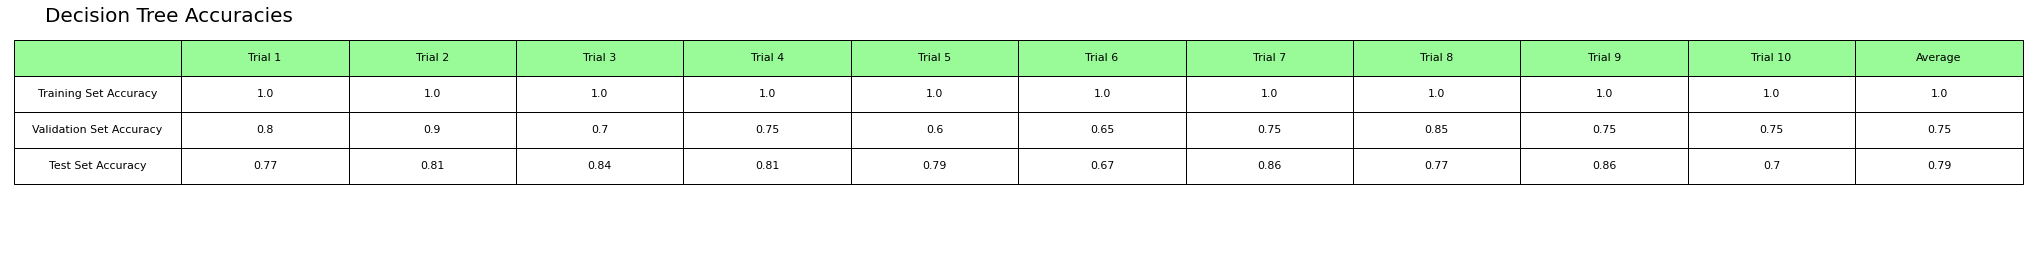

In [ ]:
# Write a function that implements 10-fold cross validation
def n_fold_CV(n, X, y):
  fold_size = int(X.shape[0] / n)

  training_accuracies_row_label = ["Training Set Accuracy"]
  validation_accuracies_row_label  = ["Validation Set Accuracy"]
  test_accuracies_row_label  = ["Test Set Accuracy"]
  training_accuracies_row = []
  validation_accuracies_row  = []
  test_accuracies_row  = []

  # Train and test decision tree on each of n blocks of data
  for i in range(n):
    start, end = i * fold_size, i * fold_size + fold_size
    X_block = X[ start:end, : ]
    y_block = y[ start:end ]

    # Divide data block into training set (75%) and test set (25%)
    split_idx = int(0.75 * X_block.shape[0])
    training_set_X_master, training_set_y_master = X_block[:split_idx, :], y_block[:split_idx]
    test_set_X, test_set_y = X_block[split_idx:, :], y_block[split_idx:]
    # Divide training set into actual training set (85%) and validation set (15%)
    split_idx = int(0.85 * training_set_X_master.shape[0])
    training_set_X, training_set_y = training_set_X_master[:split_idx, :], training_set_y_master[:split_idx]
    validation_set_X, validation_set_y = training_set_X_master[split_idx:, :], training_set_y_master[split_idx:]

    # Train decision tree on training data
    dt = DTClassifier()
    dt.fit(training_set_X, training_set_y.reshape(-1,1))

    print("Decision Tree ", i+1, ":\n", dt.to_str(), "\n")

    # Get accuracies for training, validation and test sets, append them to respective table rows
    training_accuracies_row.append( round( dt.score( training_set_X, training_set_y ), 2 ) )
    validation_accuracies_row.append( round( dt.score( validation_set_X, validation_set_y ), 2 ) )
    test_accuracies_row.append( round( dt.score( test_set_X, test_set_y ), 2 ) )

  # Append average accuracies to training, validation and test rows
  training_accuracies_row.append( round( np.mean(training_accuracies_row), 2 ) )
  validation_accuracies_row.append( round( np.mean(validation_accuracies_row), 2 ) )
  test_accuracies_row.append( round( np.mean(test_accuracies_row), 2 ) )

  # Append row labels to beginning of accuracy rows
  training_accuracies_row = np.append(training_accuracies_row_label, training_accuracies_row)
  validation_accuracies_row = np.append(validation_accuracies_row_label, validation_accuracies_row)
  test_accuracies_row = np.append(test_accuracies_row_label, test_accuracies_row)
  
  # Build table
  col_headers = ["", "Trial 1", "Trial 2", "Trial 3", "Trial 4", "Trial 5", "Trial 6", "Trial 7", "Trial 8", "Trial 9", "Trial 10", "Average"]
  table_data = [ training_accuracies_row, validation_accuracies_row, test_accuracies_row ]
  multi, ax = plt.subplots()
  multi.suptitle("Decision Tree Accuracies", fontsize=20)
  table = ax.table( cellText = table_data, colLabels = col_headers, colWidths=[0.5]*12, colColours =["palegreen"] * 12, cellLoc ='center', loc ='upper left')
  ax.set_axis_off()
  table.set_fontsize(15)
  table.scale(1,3)

# Use 10-fold CV on Cars Dataset
n_fold_CV(n=10, X=X_cars_shuffled, y=y_cars_shuffled)

Discussion

This n-fold cross validation function takes in a shuffled dataset and divides it into n blocks of equal-sized instances. For each block of instances, the function divides them into training, validation and test sets, trains a decision tree on the training set, then reports the trained decision tree's accuracies on all three sets in a visual table. The function then appends the average accuracies for each set type to the right side of the visual table.

The car dataset induced slightly different trees for each block of instances from the shuffled dataset, which would likely not happen if our dataset size had been in the order of 10,000 instances or more versus the \~1700 instances we have. Average accuracy on the training sets was much higher (around 99%) than with the validation or test sets (around 75%), which makes sense given that the decision tree did not "train" on the validation or test sets.

### 2.3 (15%) Voting Dataset 
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Create a table for your *n*-fold cross validation accuracies
- This data set has don't know data.  Discuss how your algorithm handles this

In [ ]:
# Load and shuffle voting data
!curl -o voting_master.arff 'https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff'
voting_master = np.array(arff.loadarff('voting_master.arff')[0].tolist())
X_voting_shuffled, y_voting_shuffled = shuffle(voting_master[:,:-1], voting_master[:,-1].reshape(-1,1))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40261  100 40261    0     0   216k      0 --:--:-- --:--:-- --:--:--  216k


Decision Tree  1 :
 Input 11 = b'?': 0.8730861944903673
-- Input 0 = b'?': 0.9751190649408661
-- -- prediction: b'democrat'
-- Input 0 = b'n': 0.9751190649408661
-- -- prediction: b'republican'
Input 11 = b'n': 0.8730861944903673
-- prediction: b'democrat'
Input 11 = b'y': 0.8730861944903673
-- prediction: b'republican'
 

Decision Tree  2 :
 Input 3 = b'n': 0.8026995292019139
-- Input 2 = b'n': 0.9910760598382222
-- -- prediction: b'republican'
-- Input 2 = b'y': 0.9910760598382222
-- -- prediction: b'democrat'
Input 3 = b'y': 0.8026995292019139
-- prediction: b'republican'
 

Decision Tree  3 :
 Input 2 = b'?': 0.9751190649408661
-- prediction: b'republican'
Input 2 = b'n': 0.9751190649408661
-- prediction: b'republican'
Input 2 = b'y': 0.9751190649408661
-- prediction: b'democrat'
 

Decision Tree  4 :
 Input 3 = b'?': 0.9990102708804813
-- prediction: b'republican'
Input 3 = b'n': 0.9990102708804813
-- prediction: b'democrat'
Input 3 = b'y': 0.9990102708804813
-- prediction: b'repu

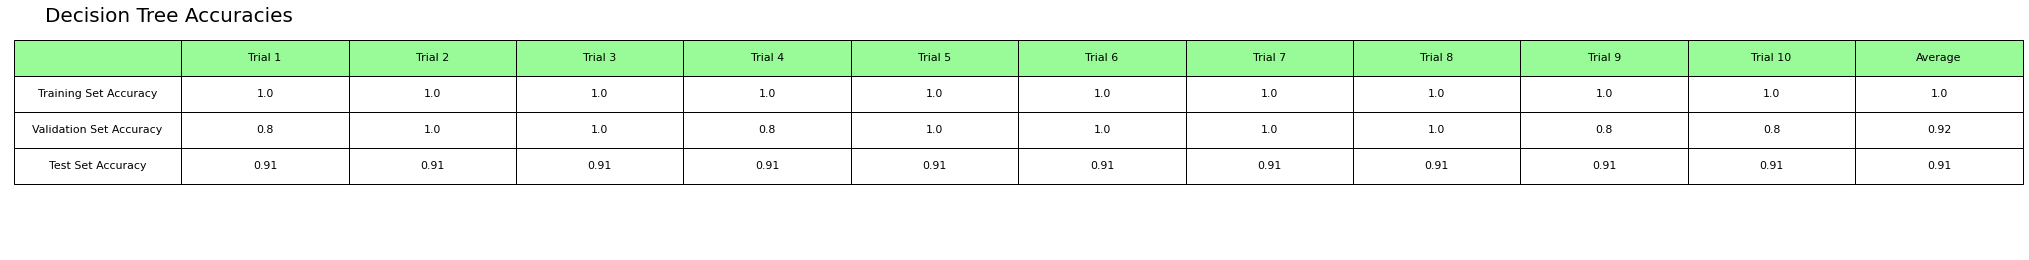

In [ ]:
# Use 10-fold CV on Voting Dataset
# Make sure it handles 'don't know' inputs
n_fold_CV(n=10, X=X_voting_shuffled, y=y_voting_shuffled)

Discussion

The decision tree learned the voting dataset decently well, as it achieved 100% average accuracy on its training sets and around 90% average accuracy for both the validation and test sets. This decision tree algorithm handles unknown values by counting them as a unique value from the start. This is achieved using numpy's unique function, which counts a '?' as a seperate category and treats it as any other value.

### 2.4 (5%) Decision Tree Intuition
- For each of the two problems above, summarize in English what the decision tree has learned (i.e. look at the induced tree and describe what "rules" it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

Discuss what the Trees have learned on the 2 data sets

On the cars dataset, the decision tree has learned that input indices 3 and 5 are the best to split on first. Input index 5 (safety) was split on first 60% of the time in this 10-fold cross validation exercise, while input index 3 (persons) was split on first 40% of them time. These two inputs represented the first two split levels of the tree in virtually all instances, with the only exceptions featuring input index 1 (maintenance) at the second split level. This shows that safety, person capacity and maintenance costs are the best predicting factors for the acceptability of a car for prospective buyers.

With the voting dataset, n-fold cross validation produced very simple decision trees that predicted political disposition with high accuracy (around 90% for validation and test sets). Input indices 2, 3 and 11 were the single splits made in virtually all blocks of instances. Input instance 2 (water project cost sharing) was split on in 30% of cases, with a 'y' or '?' response signifying a democrat and an 'n' response signifying a republican. Input instance 3 (adoption of the budget resolution) was split on in 50% of cases, with an 'n' or '?' response signifying a democrat and a 'y' response signifying a republican. Input instance 11 (synfuels corporation cutback) was split on in 20% of cases, with an 'n' or '?' resonse signifying a democrat and a 'y' response signifying a republican.

## 3 Using SciKit Learn's decision tree  

### 3.1 (10%) SK Learn on Voting Dataset
- Use SciKit learns decision tree (CART) on the voting dataset and compare the results with your ID3 version. Use this [Voting Dataset with missing values].(https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Try different parameters and report what parameters perform the best on the test set.

In [ ]:
# Use SK Learn's Decision Tree to learn the voting dataset
voting_encoded_X, voting_encoded_y = voting_master[:,:-1], voting_master[:,-1].reshape(-1,1)
le = preprocessing.LabelEncoder()
for i in range(voting_encoded_X.shape[1]):
    voting_encoded_X[:,i] = le.fit_transform(voting_encoded_X[:,i].flatten())
voting_encoded_y= le.fit_transform(voting_encoded_y.flatten()).reshape(-1,1)

# Split voting dataset into training and test sets
split_idx = int(0.75 * voting_encoded_X.shape[0])
voting_encoded_train_X, voting_encoded_train_y = voting_encoded_X[:split_idx, :], voting_encoded_y[:split_idx, :]
voting_encoded_test_X, voting_encoded_test_y = voting_encoded_X[split_idx:, :], voting_encoded_y[split_idx:, :]

voting_skl_dt = DecisionTreeClassifier(min_samples_split=3, max_depth=6)
_ = voting_skl_dt.fit(voting_encoded_train_X, voting_encoded_train_y)
# Explore different parameters
print("SciKit Learn Tree Accuracy:",voting_skl_dt.score(voting_encoded_test_X, voting_encoded_test_y),"\n")
print("Feature Importance:\n",voting_skl_dt.feature_importances_)

SciKit Learn Tree Accuracy: 0.908256880733945 

Feature Importance:
 [0.         0.         0.0245818  0.87496997 0.         0.00154466
 0.00432504 0.         0.01557015 0.01738948 0.01062554 0.01988396
 0.01557015 0.         0.01553926 0.        ]


Discuss scikit CART results & also compare to your ID3 results

The scikit CART was able to classify with 98.6% accuracy on the voting dataset that it was trained on. I fiddled with maximum depth and min_samples_split, and it seems that neither of them have much effect on overall accuracy upon adjustment. My decision tree algorithm also achieved around 92% accuracy on the voiting test data, so it performed on par with the scikit learn classifier.

### 3.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the SK decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [ ]:
# Load lymphography dataset
!curl -o lymphopraphy.data "https://archive.ics.uci.edu/ml/machine-learning-databases/lymphography/lymphography.data"
lympho_data = np.array(pd.read_csv("lymphopraphy.data"))
lympho_X, lympho_y = lympho_data[:,1:], lympho_data[:,0]

# Split lymphography datset into training and test sets
split_idx = int(0.75 * lympho_X.shape[0])
lympho_X_training, lympho_y_training = lympho_X[:split_idx, :], lympho_y[:split_idx]
lympho_X_test, lympho_y_test = lympho_X[split_idx:, :], lympho_y[split_idx:]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5624  100  5624    0     0  29756      0 --:--:-- --:--:-- --:--:-- 29756


In [ ]:
# Use SciKit Learn's Decision Tree on a new dataset
lympho_skl_dt = DecisionTreeClassifier(criterion="entropy", min_samples_split=3)
_ = lympho_skl_dt.fit(lympho_X_training, lympho_y_training)

print("SciKit Learn Tree Accuracy:",lympho_skl_dt.score(lympho_X_test, lympho_y_test),"\n")
print("Feature Importance:\n",lympho_skl_dt.feature_importances_)
# Experiment with different hyper-parameters

SciKit Learn Tree Accuracy: 0.7297297297297297 

Feature Importance:
 [0.02181462 0.15330378 0.         0.         0.         0.
 0.03844243 0.02181462 0.         0.10541108 0.01662782 0.
 0.15555699 0.05669564 0.10600575 0.09392849 0.         0.2303988 ]


Discussion

The scikit learn classifier learned the lymphography dataset from the UCI datset repository, which correlates lab findings with lymphatic diagnoses, and scored with an accuracy of around 78%, on average. The best results were obtained using entropy as the infor-gain criterion, coupled with a min_samples_split pf 3. The most important features identified by the classifier were at input indices 1 (block of affere), 14 (changes in node), and 17 (no. of nodes in).

### 3.3 (5%) Print sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first several levels (e.g. top 5).

In [ ]:
# Include decision tree visualization here
print(export_text(lympho_skl_dt))

|--- feature_17 <= 3.50
|   |--- feature_1 <= 1.50
|   |   |--- feature_14 <= 1.50
|   |   |   |--- feature_12 <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_12 >  1.50
|   |   |   |   |--- feature_15 <= 1.50
|   |   |   |   |   |--- feature_7 <= 1.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_7 >  1.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_15 >  1.50
|   |   |   |   |   |--- class: 2
|   |   |--- feature_14 >  1.50
|   |   |   |--- feature_15 <= 1.50
|   |   |   |   |--- feature_10 <= 2.50
|   |   |   |   |   |--- feature_0 <= 2.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_0 >  2.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_10 >  2.50
|   |   |   |   |   |--- class: 2
|   |   |   |--- feature_15 >  1.50
|   |   |   |   |--- feature_14 <= 2.50
|   |   |   |   |   |--- feature_9 <= 2.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_9 >  

Discussion

The scikit learn classifier seems to always split on feature 17, which is the number of included lymph nodes observed. Features 1 and 14 were always the second and third splits respectively. The tree never seemed to extend beyond a depth of 7, even without imposing a max depth restriction on the model.

## 4. (Optional 5% extra credit) Implement reduced error pruning to help avoid overfitting
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).

In [ ]:
# Reduced Error Pruning Code

Discussion